In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from analytic_solution import oscillator    
from IPython.display import display,Markdown
import matplotlib
matplotlib.rc('text', usetex = True)

The following models are trained on the following paramaters:

$k$ = 20

$m$ = 1

$t \in [0, 1]$ 

collocation points = 512

Loss function will be specified before the plots

The neural network will be trained for 10000 epochs to create the following function:
$$
        p_{k+1} = p_k + \mathcal{N}_p(q_k,t,\theta)\\
        q_{k+1} = q_k + \mathcal{N}_q(p_{k},t,\theta)
$$
for a given grid of $t$ values. That is $h$ must be specified, before training.

In [7]:
figsize = (20,10)

In [8]:
x0 = tf.reshape(tf.convert_to_tensor(1.0,dtype=tf.float64),[-1,1])
x_0 = tf.reshape(tf.convert_to_tensor(0.0,dtype=tf.float64),[-1,1])
k = tf.constant(20.0,dtype=tf.float64)
m = tf.constant(1.0,dtype=tf.float64)
h = tf.constant(1/511,dtype=tf.float64)
l = tf.constant(0.0,dtype=tf.float64)
u = tf.constant(10.0,dtype=tf.float64)

In [9]:
def make_predictions(model,l,u,x0,x_0,h):
    tt = tf.reshape(tf.convert_to_tensor(np.arange(l,u,h)),[-1,1])
    t = tf.reshape(tf.convert_to_tensor(0.,dtype=tf.float64),[-1,1])
    x0 = tf.reshape(tf.convert_to_tensor(x0,dtype=tf.float64),[-1,1])
    x_0 = tf.reshape(tf.convert_to_tensor(x_0,dtype=tf.float64),[-1,1]) 
    inp = tf.concat([t,x_0,x0], axis=1 )
    xx = []
    xx_=[]

    for i in range(len(tt)):
        t = tf.reshape(tt[i],[-1,1])
        out = model(inp)
        y,y_ = out[:,1], out[:,0]
        y,y_ = tf.reshape(y,[-1,1]), tf.reshape(y_,[-1,1])
        xx.append(y[0][0])
        inp = tf.concat([t+(i+1)*h,y_,y], axis=1 )
        xx_.append(y_[0][0])
    return np.array(xx).reshape(-1,1),np.array(xx_).reshape(-1,1),tt.numpy().reshape(-1,1)  

In [10]:
def symplectic_euler(x0,x_0,l,u,h,k,m):
    n = int((u-l)/h)
    q = np.ones(n)*x0
    p = np.ones(n)*x_0
    t = np.arange(l,u,h)
    for i in range(1,n):
        p[i] = p[i-1] + (t[i]-t[i-1])*(-k*q[i-1])
        q[i] = q[i-1] + (t[i]-t[i-1])*(p[i]/m)
    return t,p,q

First we see results without the hamiltonian regularization term

$$ \mathcal{L} = \frac{1}{N}\sum_{i=1}^N(\mathcal{N}_q(q_k,t_i,\theta) + k \cdot q_k )^2 + \frac{1}{N}\sum_{i=1}^N(\mathcal{N}_p(p_k,t_i,\theta) - \frac{p_k}{m}  )^2$$

In [11]:
import myPINN
model_without_hamiltonian = tf.keras.models.load_model("model_without_hamiltonian_collocation_points_512",compile = True) 

# The mean squared error is: 8.613000602271712e-05

# $l_2$ norm error is : 0.6634186693002273

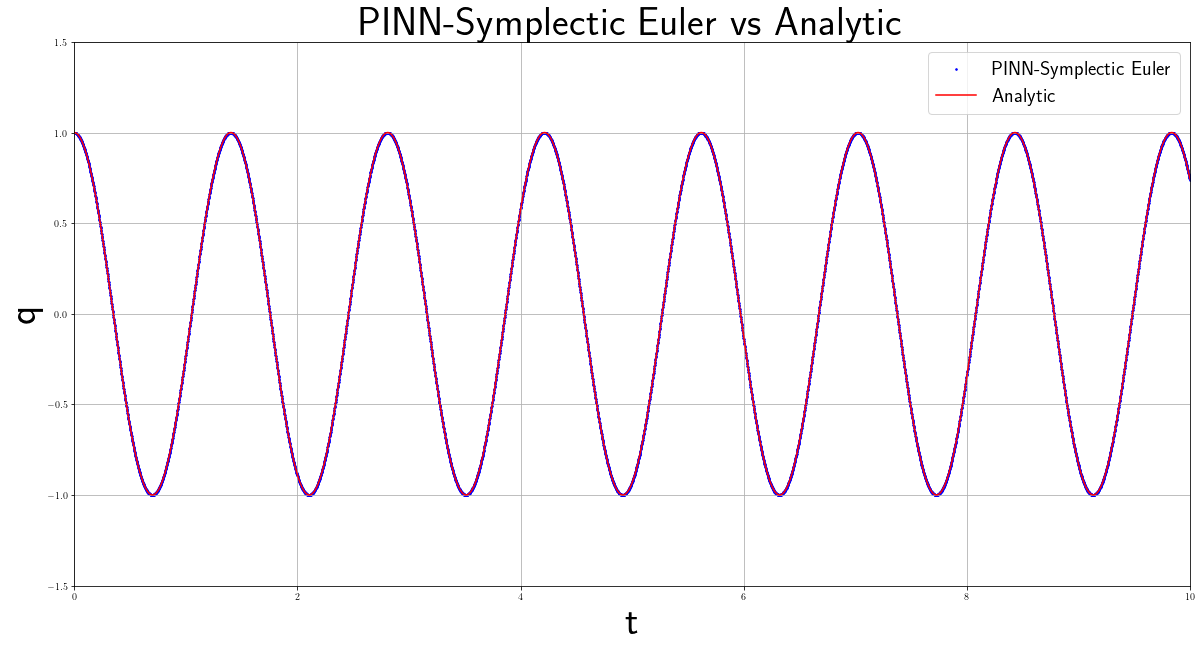

In [12]:
xx,xx_,tt = make_predictions(model_without_hamiltonian,l=l,u= u,x0=x0,x_0=x_0,h=h)   
plt.figure(figsize=figsize)
plt.scatter(tt,xx,marker=".",color ="blue",s=10) 
plt.plot(tt,oscillator(x0[0],x_0[0],np.array(tt),20.,1.),"r")
plt.title("PINN-Symplectic Euler vs Analytic",size=40)
plt.xlabel('t',size=40)
plt.ylabel('q',size=40)
plt.xlim(0,10)
plt.ylim(-1.5,1.5)
plt.grid()
plt.legend(["PINN-Symplectic Euler","Analytic"],loc="upper right",prop={'size': 20})
display(Markdown(f"# The mean squared error is: {np.mean((xx-oscillator(x0[0],x_0[0],np.array(tt),20.,1.))**2)}"))
display(Markdown(f"# $l_2$ norm error is : {np.linalg.norm(xx-oscillator(x0[0],x_0[0],np.array(tt),20.,1.),2)}"))
plt.show()

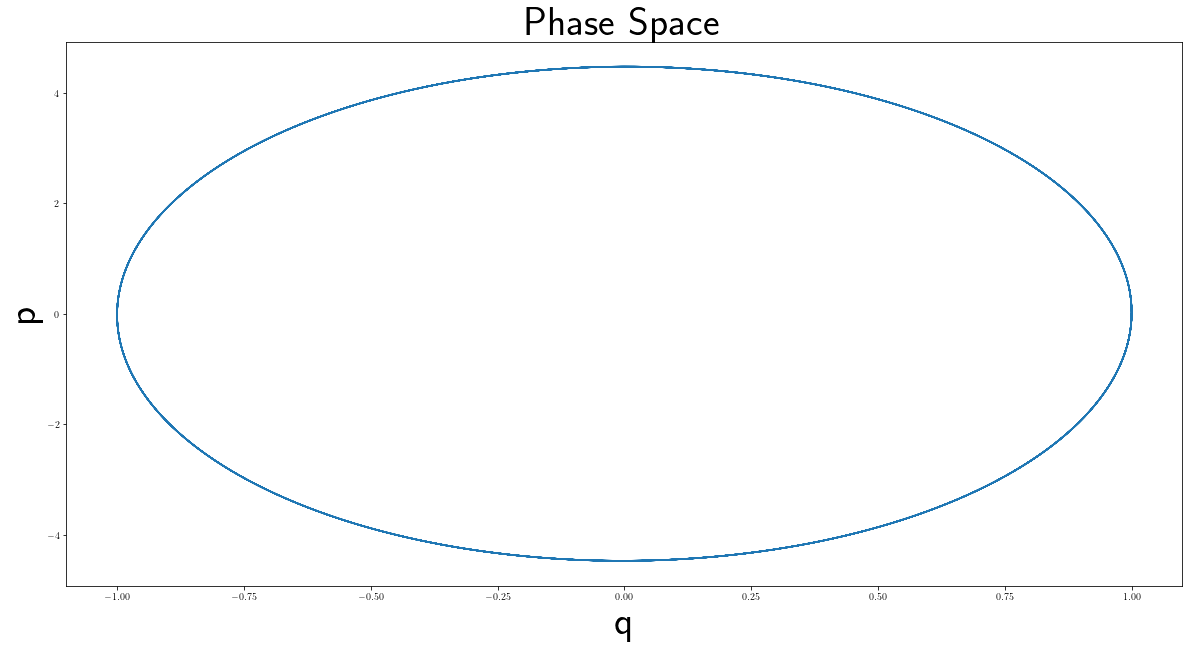

In [13]:
plt.figure(figsize=figsize)
plt.plot(xx,xx_)
plt.title("Phase Space",size=40)
plt.xlabel('q',size=40)
plt.ylabel('p',size=40)
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19760\1983081601.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,0.3)


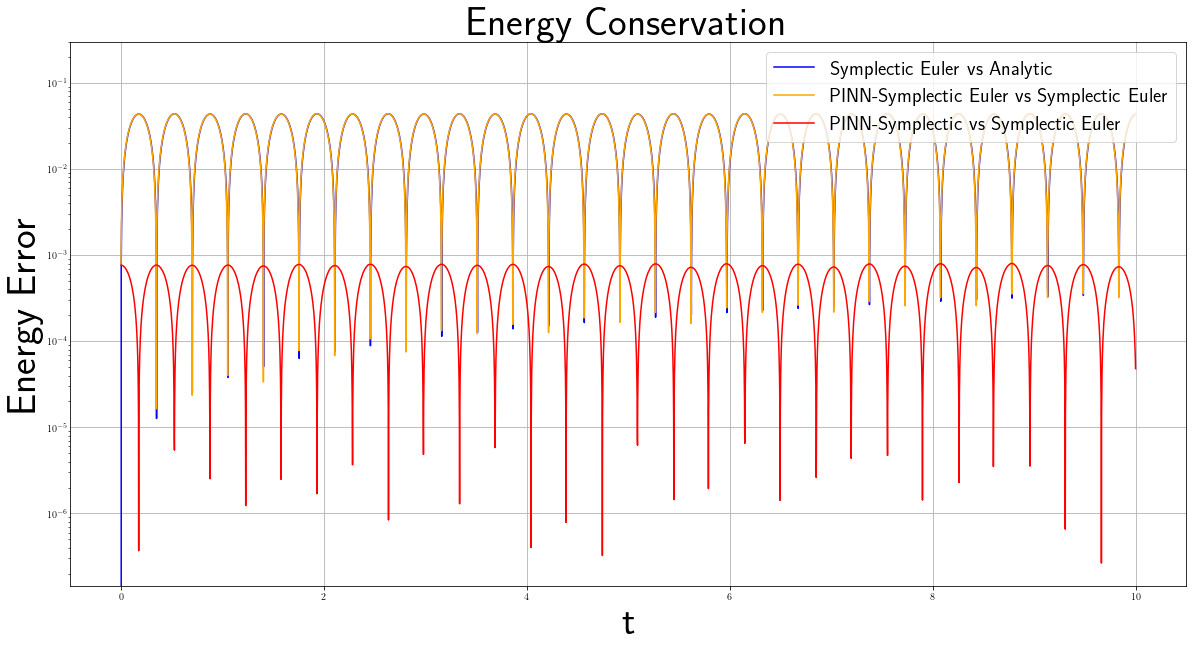

In [14]:
t,p,q = symplectic_euler(x0[0].numpy(),x_0[0].numpy(),l=l,u=u,h=h,k=k,m=m)
p = p.reshape(-1,1)
q= q.reshape(-1,1)
t = t.reshape(-1,1)
H = (0.5*(p**2)/m.numpy() + 0.5*k.numpy()*(q**2)).reshape(-1,1)
H0 = 0.5*(m*x_0[0]**2) + 0.5*k*(x0[0]**2)
H_PINN = 0.5*(np.array(xx_)**2)/m + 0.5*k*(np.array(xx)**2)
plt.figure(figsize=figsize)
plt.semilogy(t,tf.abs(H-H0),'b')
plt.semilogy(t,tf.abs(H_PINN-H0),'orange')
plt.semilogy(t,tf.abs(H_PINN-H).numpy(),'r')
plt.title("Energy Conservation",size=40)
plt.xlabel('t',size=40)
plt.ylabel('Energy Error',size=40)
plt.legend(["Symplectic Euler vs Analytic","PINN-Symplectic Euler vs Symplectic Euler","PINN-Symplectic vs Symplectic Euler"],loc="upper right",prop={'size': 20})
plt.ylim(0,0.3)
plt.grid()
plt.tick_params('y',length =20,size=0)
plt.show()

Now analysis with the hamiltonian regularization term
$$\mathcal{L} = \frac{1}{N}\sum_{i=1}^N(\mathcal{N}_q(q_k,t_i,\theta) + k \cdot q_k )^2 + \frac{1}{N}\sum_{i=1}^N(\mathcal{N}_p(p_k,t_i,\theta) - \frac{p_k}{m}  )^2 + \alpha\frac{1}{N}\sum_{i=1}^{N} \frac{(H_{t_i}-H_0)}{H_0}$$

In [27]:
import myPINN
import tensorflow as tf
model_with_hamiltonian = tf.keras.models.load_model("model",compile = True) 

In [28]:
h=tf.constant(1/100,dtype=tf.float64)

### The mean squared error is: 52.66719249538801

### $l_2$ norm error is : 229.4933386732347

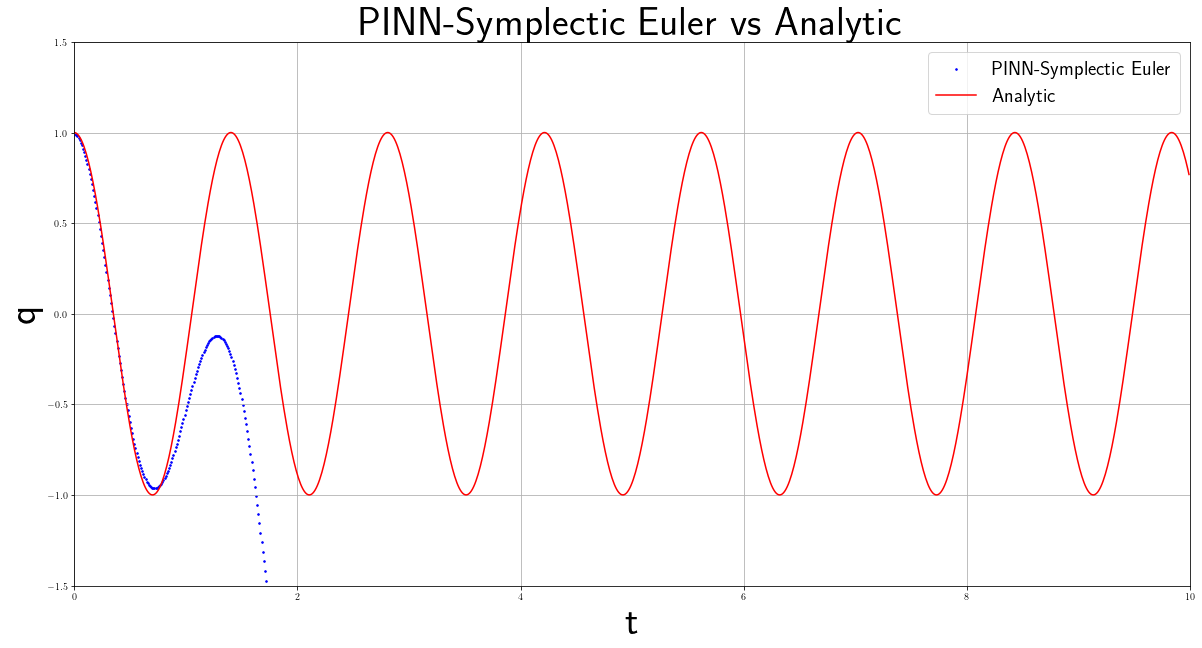

In [29]:
xx,xx_,tt = make_predictions(model_with_hamiltonian,l=l,u= u,x0=x0,x_0=x_0,h=h)   
plt.figure(figsize=figsize)
plt.scatter(tt,xx,marker=".",color ="blue",s=10) 
plt.plot(tt,oscillator(x0[0],x_0[0],np.array(tt),20.,1.),"r")
plt.title("PINN-Symplectic Euler vs Analytic",size=40)
plt.xlabel('t',size=40)
plt.ylabel('q',size=40)
plt.xlim(0,10)
plt.ylim(-1.5,1.5)
plt.grid()
plt.legend(["PINN-Symplectic Euler","Analytic"],loc="upper right",prop={'size': 20})
display(Markdown(f"### The mean squared error is: {np.mean((xx-oscillator(x0[0],x_0[0],np.array(tt),20.,1.))**2)}"))
display(Markdown(f"### $l_2$ norm error is : {np.linalg.norm(xx-oscillator(x0[0],x_0[0],np.array(tt),20.,1.),2)}"))
plt.show()

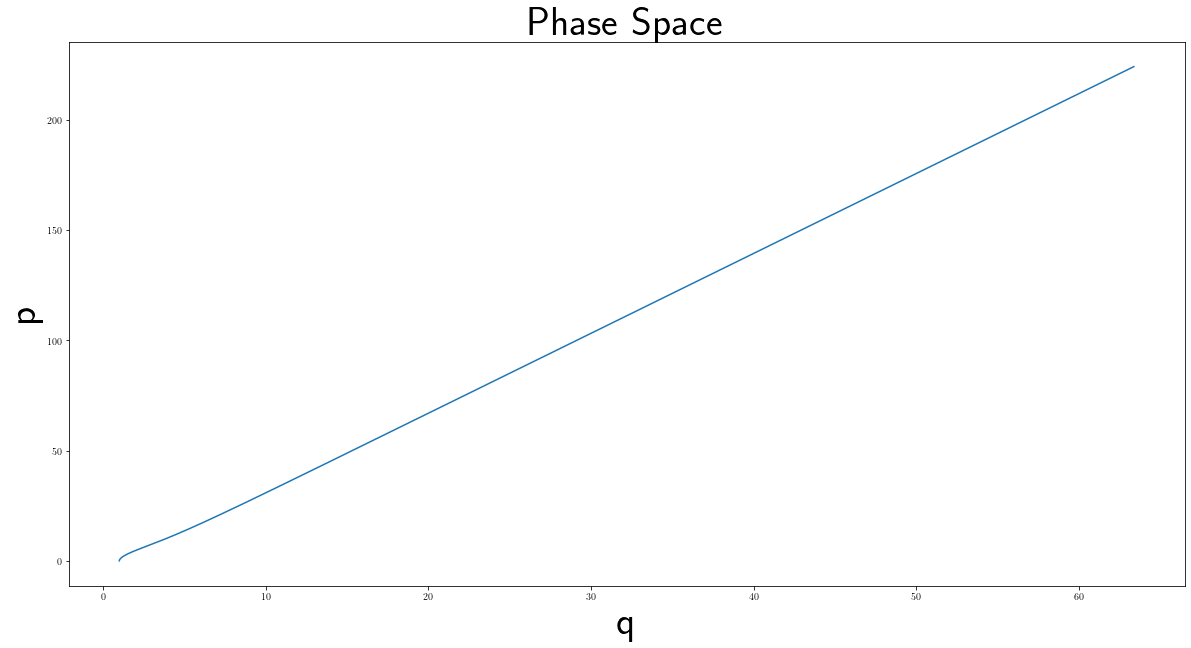

In [21]:
plt.figure(figsize=figsize)
plt.plot(xx,xx_)
plt.title("Phase Space",size=40)
plt.xlabel('q',size=40)
plt.ylabel('p',size=40)
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19760\652587591.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,0.3)


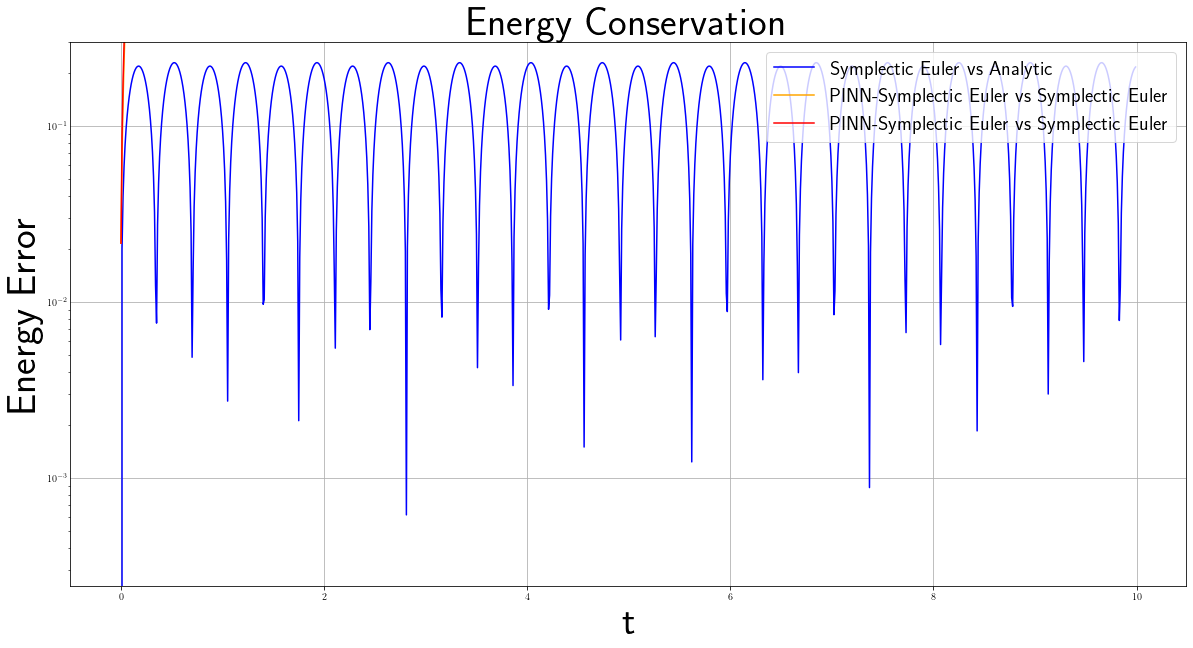

In [22]:
t,p,q = symplectic_euler(x0[0].numpy(),x_0[0].numpy(),l=l,u=u,h=h,k=k,m=m)
p = p.reshape(-1,1)
q= q.reshape(-1,1)
t = t.reshape(-1,1)
H = (0.5*(p**2)/m.numpy() + 0.5*k.numpy()*(q**2)).reshape(-1,1)
H0 = 0.5*(m*x_0[0]**2) + 0.5*k*(x0[0]**2)
H_PINN = 0.5*(np.array(xx_)**2)/m + 0.5*k*(np.array(xx)**2)
plt.figure(figsize=figsize)
plt.semilogy(t,tf.abs(H-H0),'b')
plt.semilogy(t,tf.abs(H_PINN-H0),'orange')
plt.semilogy(t,tf.abs(H_PINN-H).numpy(),'r')
plt.title("Energy Conservation",size=40)
plt.xlabel('t',size=40)
plt.ylabel('Energy Error',size=40)
plt.legend(["Symplectic Euler vs Analytic","PINN-Symplectic Euler vs Symplectic Euler","PINN-Symplectic Euler vs Symplectic Euler"],loc="upper right",prop={'size': 20})
plt.ylim(0,0.3)
plt.grid()
plt.tick_params('y',length =20,size=0)
plt.show()

In [23]:
import pandas as pd
df = pd.DataFrame(columns=["h","Error with True solution", "Error with Euler method solution", "Max error with True solution", "Max error with Euler method solution"])
df_hamiltonian = pd.DataFrame(columns=["h","Error with True solution", "Error with Euler method solution", "Max error with True solution", "Max error with Euler method solution"])
euler_df = pd.DataFrame(columns=["h","Error with True solution", "Max error with True solution"])
for i in range(3,10):
    model_without_hamiltonian = tf.keras.models.load_model(f"model_without_hamiltonian_collocation_points_{2**i}",compile = True)
    model_with_hamiltonian = tf.keras.models.load_model(f"model_with_hamiltonian_collocation_points_{2**i}",compile = True)
    xx,xx_,tt=make_predictions(model_without_hamiltonian,l=0.,u=1.,x0=1.,x_0=0.,h=1/(2**i-1))
    true_solution = oscillator(x0[0],x_0[0],np.array(tt),20.,1.)
    t_euler,p_euler,q_euler = symplectic_euler(x0[0].numpy(),x_0[0].numpy(),0.,1.,1/(2**i-1),20.,1.)
    df =pd.concat([df,pd.DataFrame([[1/(2**i-1), np.linalg.norm(true_solution-xx,2),np.linalg.norm(q_euler.reshape(-1,1)-xx,2),np.linalg.norm(true_solution-xx,np.inf),np.linalg.norm(q_euler.reshape(-1,1)-xx,np.inf)]],columns=df.columns)])
    euler_df = pd.concat([euler_df,pd.DataFrame([[1/(2**i-1),np.linalg.norm(true_solution-q_euler.reshape(-1,1),2),np.linalg.norm(true_solution-q_euler.reshape(-1,1), np.inf)]],columns=euler_df.columns)])
    xx,xx_,tt=make_predictions(model_with_hamiltonian,l=0.,u=1.,x0=1.,x_0=0.,h=1/(2**i-1))
    df_hamiltonian = pd.concat([df_hamiltonian,pd.DataFrame([[1/(2**i-1), np.linalg.norm(true_solution-xx,2),np.linalg.norm(q_euler.reshape(-1,1)-xx,2),np.linalg.norm(true_solution-xx,np.inf),np.linalg.norm(q_euler.reshape(-1,1)-xx,np.inf)]],columns=df_hamiltonian.columns)])
df.to_csv("error.csv")

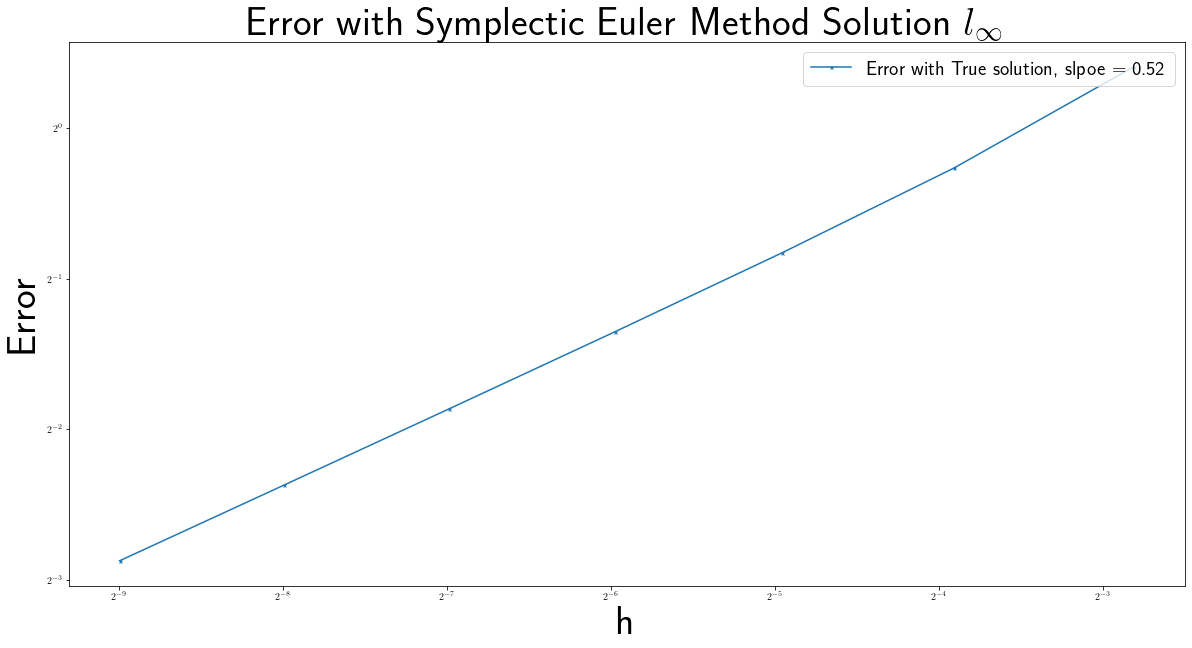

In [24]:
a,b = np.polyfit(np.log(df["h"].values.astype(float)),np.log(df["Error with Euler method solution"].values.astype(float)),1)
plt.figure(figsize=figsize)
plt.loglog(df["h"],df["Error with Euler method solution"], base = 2,marker='x', markersize=3)
plt.legend(["Error with True solution, slpoe = "+str(a)[:4]],loc="upper right",prop={'size': 20})
plt.title(r'Error with Symplectic Euler Method Solution $l_\infty$',size=40)
plt.xlabel("h",size=40)
plt.ylabel("Error",size=40) 
plt.show()

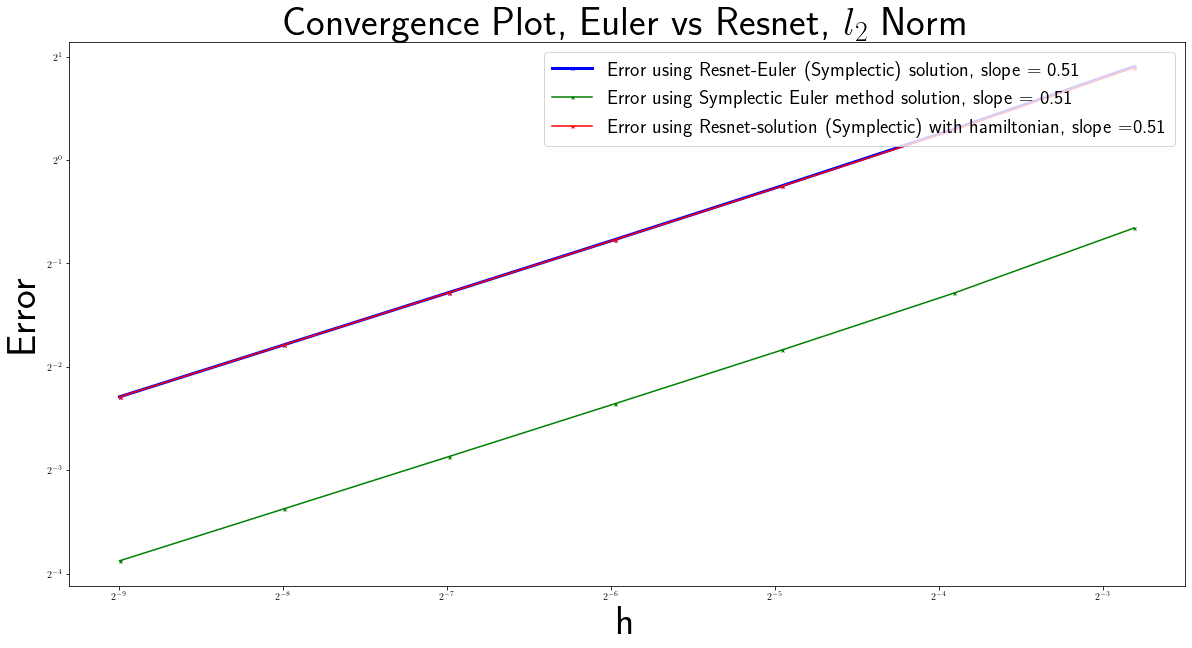

In [25]:
import numpy as np
a,_ = np.polyfit(np.log(df["h"].values.astype(float)),np.log(df["Error with True solution"].values.astype(float)),1)
b,_ =np.polyfit(np.log(euler_df['h'].values.astype(float)),np.log(euler_df["Error with True solution"].values.astype(float)),1)
c,_ = np.polyfit(np.log(df_hamiltonian["h"].values.astype(float)),np.log(df_hamiltonian["Error with True solution"].values.astype(float)),1)
plt.figure(figsize=figsize)
plt.loglog(df["h"],df["Error with True solution"], base = 2,marker='x', markersize=3,color="blue",linewidth=3)
plt.loglog(euler_df['h'],euler_df["Error with True solution"], base = 2,marker='x', markersize=3,color="green")
plt.loglog(df_hamiltonian["h"],df_hamiltonian["Error with True solution"], base = 2,marker='x', markersize=3,color="red")
plt.legend(["Error using Resnet-Euler (Symplectic) solution, slope = "+str(a)[:4],"Error using Symplectic Euler method solution, slope = "+str(b)[:4],"Error using Resnet-solution (Symplectic) with hamiltonian, slope =" + str(c)[:4]],loc="upper right",prop={'size': 20})
plt.title("Convergence Plot, Euler vs Resnet, $l_2$ Norm",size=40)
plt.xlabel('h',size=40)
plt.ylabel('Error',size=40)
plt.show()

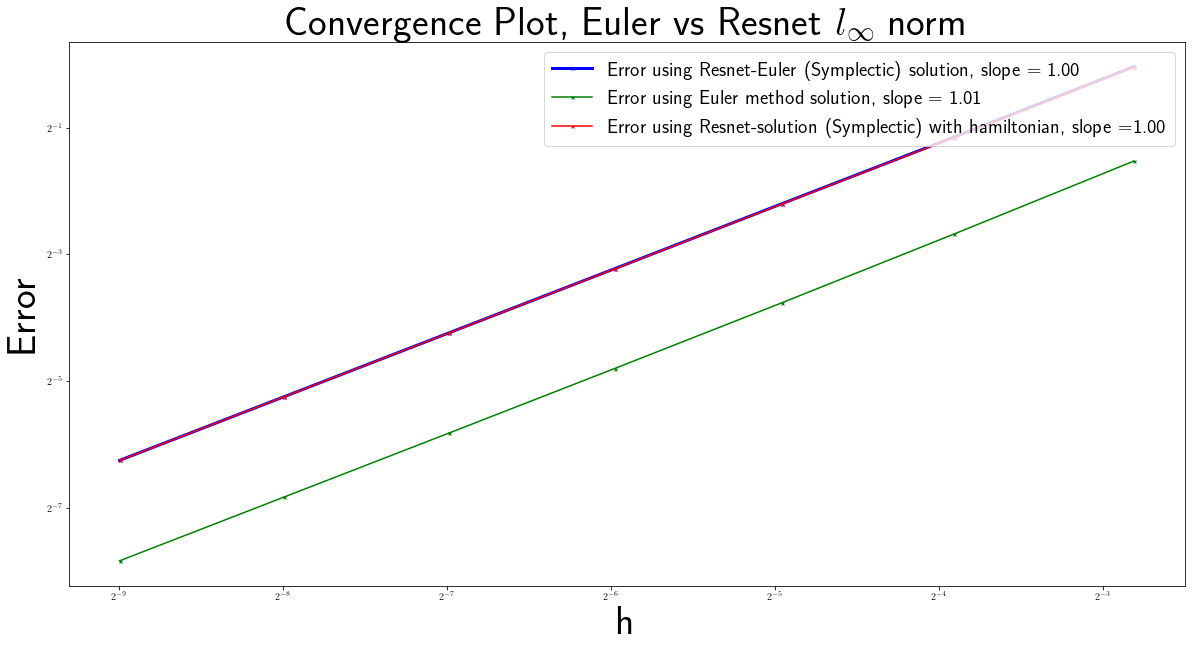

In [26]:
import numpy as np
a,_ = np.polyfit(np.log(df["h"].values.astype(float)),np.log(df["Max error with True solution"].values.astype(float)),1)
b,_ =np.polyfit(np.log(euler_df['h'].values.astype(float)),np.log(euler_df["Max error with True solution"].values.astype(float)),1)
c,_ = np.polyfit(np.log(df_hamiltonian["h"].values.astype(float)),np.log(df_hamiltonian["Max error with True solution"].values.astype(float)),1)
plt.figure(figsize=figsize)
plt.loglog(df["h"],df["Max error with True solution"], base = 2,marker='x', markersize=3,color="blue",linewidth=3)
plt.loglog(euler_df['h'],euler_df["Max error with True solution"], base = 2,marker='x', markersize=3,color="green")
plt.loglog(df_hamiltonian["h"],df_hamiltonian["Max error with True solution"], base = 2,marker='x', markersize=3,color="red")
plt.legend(["Error using Resnet-solution solution, slope = "+str(a)[:4],"Error using Symplectic Euler method solution, slope = "+str(b)[:4]],loc="upper right",prop={'size': 20})
plt.legend(["Error using Resnet-Euler (Symplectic) solution, slope = "+str(a)[:4],"Error using Euler method solution, slope = "+str(b)[:4],"Error using Resnet-solution (Symplectic) with hamiltonian, slope =" + str(c)[:4]],loc="upper right",prop={'size': 20})
plt.title(r"Convergence Plot, Euler vs Resnet $l_\infty$ norm",size=40)
plt.xlabel('h',size=40)
plt.ylabel('Error',size=40)
plt.show()